In [ ]:
%%capture
# For Google Colab:
!pip install kats
!wget https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/air_passengers.csv
!wget https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/multi_ts.csv

In [ ]:
# https://facebookresearch.github.io/Kats/

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("MLTollsStackOverflow.csv")

# Turn the month column into datetime
df["month"] = pd.to_datetime(df["month"], format="%y-%b")
df = df.set_index("month")
df

,nltk,spacy,stanford-nlp,python,r,numpy,scipy,matlab,machine-learning,pandas,pytorch,keras,nlp,apache-spark,hadoop,pyspark,python-3.x,tensorflow,deep-learning,neural-network,lstm,time-series,pillow,rasa,opencv,pipenv,seaborn,Dask,jupyter,AllenNLP,Theano,plotly,scikit-learn,BeautifulSoup,scrapy,Gensim,FastText,Pydot,Pybrain,Pytil,...,Colab,Shogun,KNIME,Apache,Gunicorn,Pygtk,Weka,Conda,Ray,matlab.1,accord.net,regression,classification,correlation,cluster-analysis,H2o,Mallet,Numba,Tableau,Trifacta,PyArrow,Rasterio,Orange3,PyMC3,Opennn,Oryx,Istio,Venes,Plotnine,Gluon,Plato,Sympy,Flair,stanford-nlp.1,pyqt,Nolearn,Lasagne,OCR,Apache-spark-mlib,azure-virtual-machine
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-01,0,0,0,631,8,6,2,19,8,0,0,0,8,0,1,0,4,0,0,4,0,1,0,0,3,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,...,0,0,0,95,0,3,0,0,0,19,0,1,2,0,1,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,0,0,5,0,0
2009-02-01,1,0,0,633,9,7,3,27,4,0,0,0,9,0,1,0,12,0,0,4,0,2,0,0,1,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,...,0,0,0,114,0,7,0,0,0,27,0,3,4,0,1,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,11,0,0
2009-03-01,0,0,0,766,4,4,2,24,3,0,0,0,12,0,1,0,4,0,0,11,0,1,0,0,7,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,...,0,0,0,104,0,6,0,0,0,24,0,0,0,0,4,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,2,0,0
2009-04-01,0,0,0,768,12,6,3,32,10,0,0,0,14,0,6,0,10,0,0,6,0,0,0,0,8,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,...,0,0,0,111,0,3,0,0,0,32,0,0,4,0,2,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,5,0,0
2009-05-01,1,0,0,1003,2,7,2,42,7,0,0,0,9,0,3,0,19,0,0,7,0,0,0,0,10,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,...,0,0,0,127,0,5,0,0,0,42,0,2,0,0,6,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,57,76,24,20257,4486,1111,212,371,583,3675,253,889,237,922,216,0,6133,1332,373,191,112,141,0,19,605,31,119,66,104,0,7,137,323,322,205,30,6,2,0,0,...,91,2,5,388,38,2,3,91,12,325,3,60,62,22,47,24,0,23,NaN,1,20,3,2,6,0,0,56,0,4,10,0,33,0,22,144,0,0,40,16,25
2019-09-01,54,62,16,19207,4474,1020,135,362,538,3298,260,786,207,913,207,0,5748,1217,334,211,93,156,0,25,556,24,90,73,107,1,9,139,324,330,146,30,14,2,1,0,...,103,0,3,435,51,5,15,103,12,362,1,76,55,35,50,39,5,25,NaN,1,25,6,5,7,0,0,65,0,4,6,0,39,0,15,147,0,4,49,28,16
2019-10-01,73,79,27,23414,5138,1310,188,523,750,4098,300,929,272,1075,260,0,6621,1468,451,265,131,203,0,16,648,36,130,73,132,0,19,174,415,350,165,27,15,1,0,0,...,120,1,4,402,55,3,12,120,18,522,4,125,81,37,65,23,2,31,NaN,0,19,7,9,3,0,0,49,0,5,6,0,72,0,27,170,0,3,70,21,19


In [6]:
python = df["python"].to_frame()

# Split data into train and test set
train_len = 102
train = python.iloc[:train_len]
test = python.iloc[train_len:]

In [7]:
from kats.consts import TimeSeriesData

# Construct TimeSeriesData object
ts = TimeSeriesData(train.reset_index(), time_col_name="month")

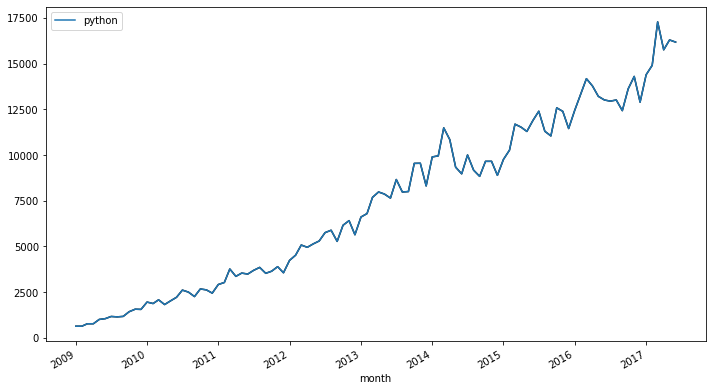

In [8]:
ts.plot(cols=["python"])

In [10]:
from kats.models.prophet import ProphetModel, ProphetParams

# Specify parameters
params = ProphetParams(seasonality_mode="multiplicative")

# Create a model instance
m = ProphetModel(ts, params)

# Fit mode
m.fit()

# Forecast
fcst = m.predict(steps=30, freq="MS")
fcst

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,time,fcst,fcst_lower,fcst_upper
0,2017-07-01,15723.041210,15228.766576,16240.059657
1,2017-08-01,15052.424297,14558.615920,15568.571389
2,2017-09-01,14358.842111,13869.720172,14829.156011
3,2017-10-01,15997.133144,15485.944654,16479.252053
4,2017-11-01,16249.837587,15717.353296,16715.869752
5,2017-12-01,14568.874858,14043.854184,15109.656421
6,2018-01-01,16332.052412,15830.884282,16866.153442
7,2018-02-01,16881.009247,16368.311202,17402.944925
8,2018-03-01,19041.386253,18545.973691,19559.154961
9,2018-04-01,18006.342105,17520.761136,18497.625981


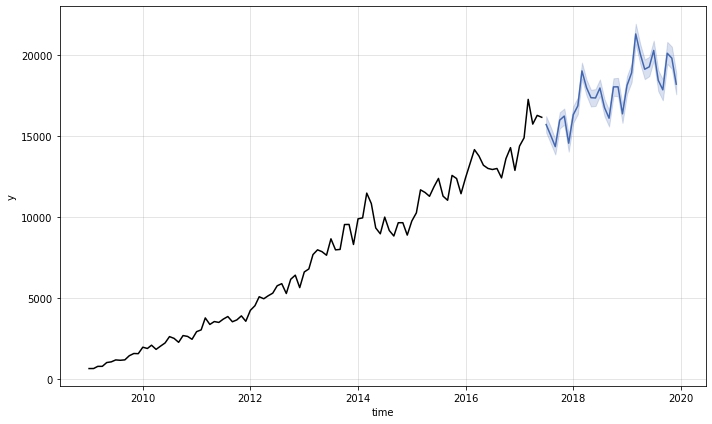

In [11]:
m.plot()

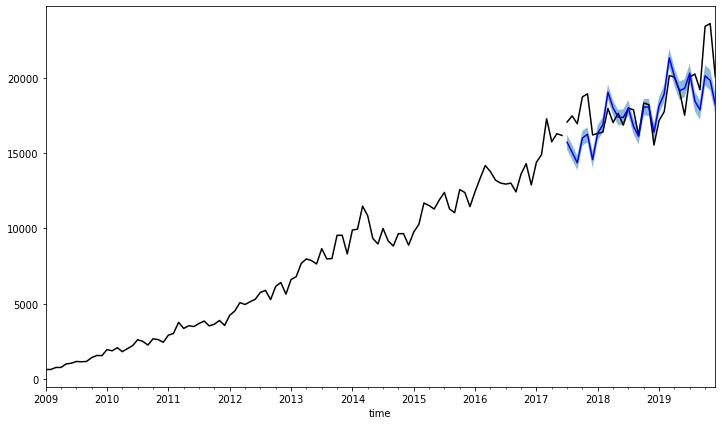

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 7))

train.plot(ax=ax, label="train", color="black")
test.plot(ax=ax, color="black")
fcst.plot(x="time", y="fcst", ax=ax, color="blue")

ax.fill_between(test.index, fcst["fcst_lower"], fcst["fcst_upper"], alpha=0.5)
ax.get_legend().remove()

In [ ]:
#API of all models : https://facebookresearch.github.io/Kats/api/kats.models.html

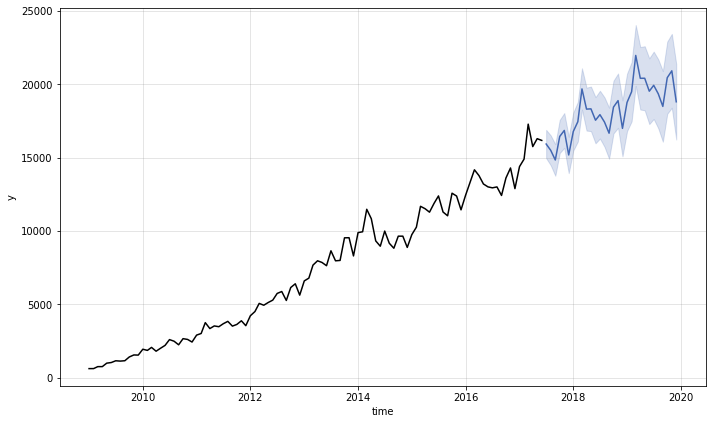

In [13]:
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
import warnings
warnings.simplefilter(action='ignore')

params = HoltWintersParams(
            trend="add",
            seasonal="mul",
            seasonal_periods=12,
        )
m = HoltWintersModel(
    data=ts, 
    params=params)

m.fit()
fcst = m.predict(steps=30, alpha = 0.1)
m.plot()

The change point is on 2013-02-01 00:00:00


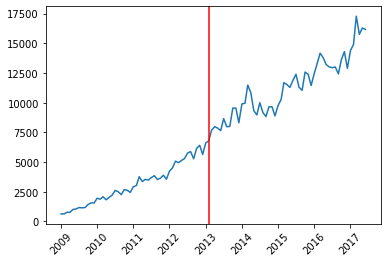

In [17]:
from kats.consts import TimeSeriesData, TimeSeriesIterator
from kats.detectors.cusum_detection import CUSUMDetector
import matplotlib.pyplot as plt

detector = CUSUMDetector(ts)

change_points = detector.detector(change_directions=["increase", "decrease"])
print("The change point is on", change_points[0][0].start_time)

# plot the results
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [18]:
def get_ts(topic: str):
    return TimeSeriesData(df[topic].to_frame().reset_index(), time_col_name="month")

def detect_change_point(topic: str):
    ts = get_ts(topic)
    detector = CUSUMDetector(ts)

    change_points = detector.detector()
    for change_point in change_points:
        print("The change point is on", change_point[0].start_time)

    # plot the results
    plt.xticks(rotation=45)
    detector.plot(change_points)
    plt.show()

The change point is on 2015-12-01 00:00:00


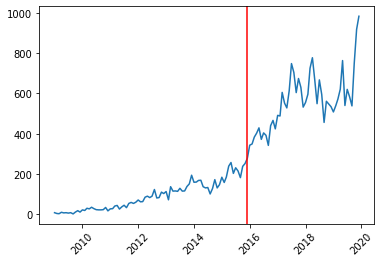

In [19]:
detect_change_point("machine-learning")

The change point is on 2015-11-01 00:00:00


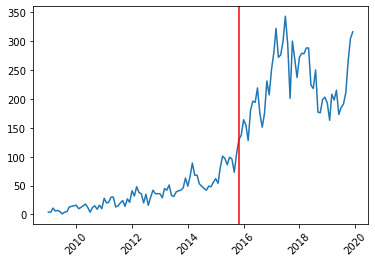

In [20]:
detect_change_point("neural-network")

The change point is on 2016-09-01 00:00:00


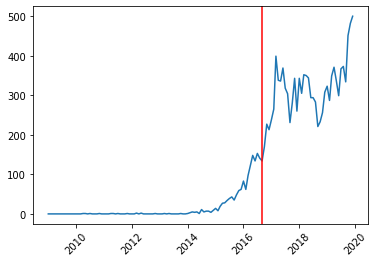

In [21]:
detect_change_point("deep-learning")

The change point is on 2015-07-01 00:00:00


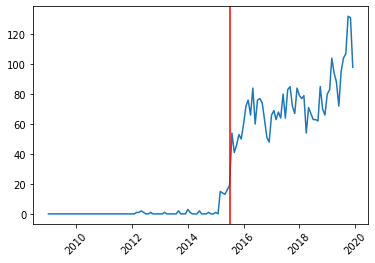

In [22]:
detect_change_point("jupyter")

The change point is on 2016-02-01 00:00:00


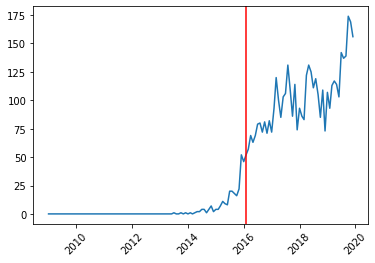

In [23]:
detect_change_point("plotly")

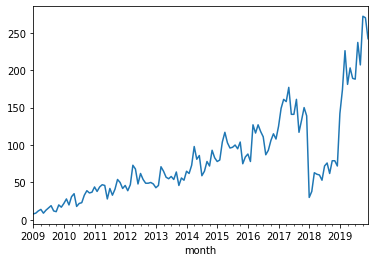

In [24]:
df["nlp"].plot()

In [26]:
from kats.detectors.outlier import OutlierDetector

# Get time series object
ts = get_ts("nlp")

# Detect outliers
ts_outlierDetection = OutlierDetector(ts, "additive")
ts_outlierDetection.detector()

# Print outliers
outlier_range1 = ts_outlierDetection.outliers[0]
print(f"The outliers range from {outlier_range1[0]} to {outlier_range1[1]}")

The outliers range from 2018-01-01 00:00:00 to 2019-03-01 00:00:00


In [27]:
from kats.tsfeatures.tsfeatures import TsFeatures

model = TsFeatures()

output_features = model.transform(ts)
output_features

{'binarize_mean': 0.3712121212121212,
 'crossing_points': 12,
 'diff1y_acf1': -0.18198552521807973,
 'diff1y_acf5': 0.042512227483500226,
 'diff1y_pacf5': 0.04707084347237743,
 'diff2y_acf1': -0.5556202545279165,
 'diff2y_acf5': 0.32795020908198114,
 'diff2y_pacf5': 0.5922575911252337,
 'entropy': 0.593975421741251,
 'firstmin_ac': 14,
 'firstzero_ac': 53,
 'flat_spots': 2,
 'heterogeneity': 107.05029630369836,
 'histogram_mode': 34.4,
 'holt_alpha': 0.7833725636281134,
 'holt_beta': 0.00011310282242817052,
 'hurst': 0.10615642677716386,
 'hw_alpha': 0.7267317300819517,
 'hw_beta': 2.73204458790906e-10,
 'hw_gamma': 0.0,
 'length': 132,
 'level_shift_idx': 109,
 'level_shift_size': 11.700000000000017,
 'linearity': 0.648882727236505,
 'lumpiness': 3177030.8722243286,
 'mean': 80.78787878787878,
 'peak': 6,
 'seas_acf1': 0.5028525530929152,
 'seas_pacf1': 0.05320528022792519,
 'seasonality_strength': 0.5049236479343631,
 'spikiness': 3.5364872539979357,
 'stability': 2126.908016700062,


In [ ]:
#Awesome!